In [7]:
from pathlib import Path
import os, json

CONFIG = "dataset_config.json"

def save_config(root):
    with open(CONFIG, "w") as f:
        json.dump({"dataset_root": str(root)}, f)

def repo_root():
    cwd = Path.cwd().resolve()
    if (cwd / "data").exists():
        return cwd
    if cwd.name == "main_code" and (cwd.parent / "data").exists():
        return cwd.parent.resolve()
    return cwd

def find_jpeg_dir(root):
    root = Path(root)
    for r, dirs, _ in os.walk(root):
        if "JPEGImages" in dirs:
            return Path(r) / "JPEGImages"
    return None

def ensure_dataset():
    base = repo_root() / "data" / "processed"
    candidates = [
        base / "PASCAL_VOC" / "PASCAL_VOC",
        base / "PASCAL_VOC",
        base
    ]
    json_names = {"pascal_train2007.json", "pascal_val2007.json", "pascal_test2007.json"}
    for target in candidates:
        if target.is_dir():
            json_ok = all((target / j).exists() for j in json_names)
            if json_ok or find_jpeg_dir(target):
                save_config(target)
                print("Using dataset under:", target)
                return target
    raise RuntimeError("Dataset not found. Expected under one of: " + ", ".join(str(c) for c in candidates))

dataset_root = Path(ensure_dataset())

Using dataset under: C:\Users\giaco\Desktop\Projects\V&C\PASCAL_VOC_2007\data\processed\PASCAL_VOC\PASCAL_VOC


In [15]:
# percorsi relativi: usiamo i JSON in data/processed/PASCAL_VOC/PASCAL_VOC (train/val/test)
import os
import json
from pathlib import Path

json_dir = dataset_root
json_dir_str = str(json_dir)
processed_root = json_dir.parent.parent  # saliamo a data/processed per trovare VOCtrainval/VOCtest
train_json = json_dir / "pascal_train2007.json"
val_json = json_dir / "pascal_val2007.json"
test_json = json_dir / "pascal_test2007.json"

trainval_jpeg_dir = processed_root / "VOCtrainval_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"
test_jpeg_dir = processed_root / "VOCtest_06-Nov-2007" / "VOCdevkit" / "VOC2007" / "JPEGImages"

with open(train_json, "r") as f:
    data = json.load(f)

def candidate_image_paths(fname):
    # usiamo direttamente i percorsi dichiarati, senza ricerca ricorsiva
    return [
        trainval_jpeg_dir / fname,
        test_jpeg_dir / fname,
    ]

# ispezioniamo il contenuto
print("Keys in the JSON file:", data.keys())
# ci sono le chiavi: images, type, annotations, categories

# ispezioniamo le prime 5 immagini
print("First 5 images:", data['images'][:5])
# ispezioniamo le prime 5 annotazioni
print("First 5 annotations:", data['annotations'][:5])
# ispezioniamo le categorie
print("Categories:", data['categories'])
# ispezioniamo il tipo di dataset
print("Type of dataset:", data['type'])

# visualizziamo 3 immagini e basta
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def visualize_image(image_id):
    image_info = next(img for img in data['images'] if img['id'] == image_id)
    fname = image_info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Immagine {fname} non trovata. Percorsi provati: {[str(p) for p in candidate_image_paths(fname)]}")

    image = plt.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
    for ann in annotations:
        bbox = ann['bbox']
        category_name = next(cat['name'] for cat in data['categories'] if cat['id'] == ann['category_id'])
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 10, category_name, color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

Keys in the JSON file: dict_keys(['images', 'type', 'annotations', 'categories'])
First 5 images: [{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}, {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}, {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}, {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26}, {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]
First 5 annotations: [{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}, {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]], 'area': 13110, 'iscrowd': 0, 'image_id': 17, 'bbox': [184, 61, 95, 138], 'category_id': 15, 'id': 2, 'ignore': 0}, {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]], 'area': 81326, 'iscrowd': 0, 'image_id': 17, 'bbox': [89, 77, 314, 259], 'category_id': 13, 'id': 3, 'ignore': 0}, {'segmentation': [[

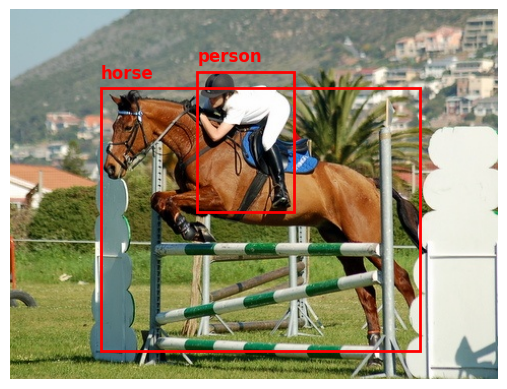

In [16]:
visualize_image(17)

In [17]:
# so now we have a dataset and we want to create a CNN to train on it and recognize objects in images

import torch
import torch.nn as nn
import torch.optim as optim
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
                nn.Linear(32 * 56 * 56, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
num_classes = len(data['categories'])
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# now we need to train it on the dataset
# but first we need to create a DataLoader for the dataset
from torch.utils.data import Dataset, DataLoader
from PIL import Image
class PascalVOCDataset(Dataset):
    def __init__(self, data, root, transform=None):
        self.data = data
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.data['images'])

    def __getitem__(self, idx):
        image_info = self.data['images'][idx]
        fname = image_info['file_name']

        image_path = None
        for c in candidate_image_paths(fname):
            if os.path.exists(c):
                image_path = c
                break

        if image_path is None:
            raise FileNotFoundError(
                f"Immagine {fname} non trovata. Percorsi provati: {[str(p) for p in candidate_image_paths(fname)]}")

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # per semplicità, prendiamo solo la prima annotazione
        annotations = [ann for ann in self.data['annotations'] if ann['image_id'] == image_info['id']]
        label = annotations[0]['category_id'] - 1  # assuming category_id starts from 1

        return image, label
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = PascalVOCDataset(data, dataset_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
# training loop
from tqdm.notebook import tqdm
num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    total_batches = len(dataloader)
    for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (batch_idx+1) % 10 == 0 or (batch_idx+1) == total_batches:
            pct = 100*(batch_idx+1)/total_batches
            tqdm.write(f"Epoch {epoch+1}/{num_epochs} - Batch {batch_idx+1}/{total_batches} ({pct:.1f}%) - Loss batch: {loss.item():.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/total_batches:.4f}")

# save the trained model
torch.save(model.state_dict(), "simple_cnn_pascalvoc.pth")  


Epoch 1/5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/5 - Batch 10/79 (12.7%) - Loss batch: 2.9557


In [ ]:
# let's see how it behaves on evaluation using the relative path under data/processed
eval_json = val_json
with open(eval_json, 'r') as f:
    eval_data = json.load(f)
eval_dataset = PascalVOCDataset(eval_data, dataset_root, transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False)
# evaluation loop
model.eval()
correct = 0
total = 0   
with torch.no_grad():
    for images, labels in eval_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy on evaluation dataset: {accuracy:.2f}%')



Accuracy on evaluation dataset: 21.63%


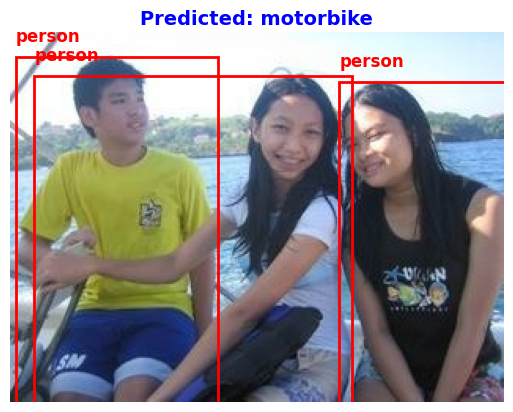

In [ ]:
# visualizziamo una immagine del dataset di valutazione con le predizioni del modello 

def visualize_image_with_predictions(image_id):
    image_info = next(img for img in eval_data['images'] if img['id'] == image_id)
    fname = image_info['file_name']

    image_path = None
    for c in candidate_image_paths(fname):
        if os.path.exists(c):
            image_path = c
            break

    if image_path is None:
        raise FileNotFoundError(
            f"Immagine {fname} non trovata. Percorsi provati: {[str(p) for p in candidate_image_paths(fname)]}")

    image = plt.imread(image_path)
    input_image = transform(Image.open(image_path).convert('RGB')).unsqueeze(0)

    model.eval()
    with torch.no_grad():
        outputs = model(input_image)
        _, predicted = torch.max(outputs.data, 1)
        predicted_label = predicted.item()

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    annotations = [ann for ann in eval_data['annotations'] if ann['image_id'] == image_id]
    for ann in annotations:
        bbox = ann['bbox']
        category_name = next(cat['name'] for cat in eval_data['categories'] if cat['id'] == ann['category_id']) 
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 10, category_name, color='red', fontsize=12, weight='bold')
    predicted_category_name = next(cat['name'] for cat in eval_data['categories'] if cat['id'] == predicted_label + 1)
    plt.title(f'Predicted: {predicted_category_name}', color='blue', fontsize=14, weight='bold')
    plt.axis('off')
    plt.show()

# senza specificare l'id immagine, ne peschiamo una a caso
import random
random_image_id = random.choice(eval_data['images'])['id']
visualize_image_with_predictions(random_image_id)